In [1]:
%matplotlib notebook 
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Estimating ECS from recent transient observations

We assume a simple energy balance model of the climate system, where an external forcing $\Delta F$ leads to a radiative response and an energy imbalance at the top of the atmosphere
$$\Delta F = \lambda \Delta T + \Delta Q$$
The quantity $\lambda$ represents the climate feedback and here, is assumed to be constant in time (we'll revisit this likely flawed assumption later).  

Equilibrium climate sensitivity $S$ is defined as the temperature change at equilibrium in response to a doubling of CO$_2$.  By definition, at equilibrium we have $\Delta Q =0$ and 
$$S = \frac{F_{2\times CO_2} }{\lambda}$$

If (and this is a big if) the feedbacks are constant in time, then the estimated sensitivity from historical observations 
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
is equal to the equilibrium sensitivity ($S=S_{hist}$).



We have observations of the temperature change $\Delta T$ and the rate of ocean heat uptake $\Delta Q$ (roughly equivalent to the TOA imbalance because the land heat capacity is negligible).  We can estimate the radiative forcing $\Delta F$ from inventories of CO$_2$ emissons and aerosol burden.  The uncertainites in these quantities are (initially) assumed to be Gaussian).


In [99]:

dT = np.random.normal(loc=0.91,scale=0.11/1.96,size=nsamp)
dQ = np.random.normal(0.61,0.14/1.96,size=nsamp)

Now, take samples of F and $F_{2\times CO_2}$

In [100]:
dF2xCO2_dist =np.random.normal(3.8,0.74/1.96,size=nsamp)
F2x=3.8
dF = dF2xCO2_dist - np.random.normal(1.46,0.77/1.96,size=nsamp) 

In [101]:
simple_model=F2x*dT/(dF-dQ)
ECS_best_guess=np.median(simple_model)
print("Best guess ECS = "+str(ECS_best_guess))

Best guess ECS = 1.9624366773138031


Collate into a single array:

x=$\Delta F$

y=$\Delta Q$

z=$\Delta T$

In [102]:
values = np.zeros((3,nsamp))
values[2]=dT
values[0]=dF
values[1]=dQ

Now calculate a kernel density estimate from these samples

In [103]:
kde = stats.gaussian_kde(values)

Evaluate the kernel density at the samples in order to plot

Text(0.5, 0, '$\\Delta$T')

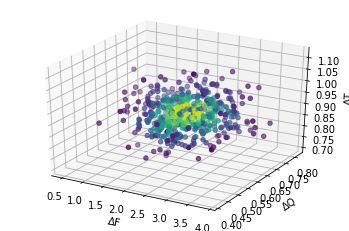

In [104]:
density = kde(values)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')

If $S_{hist}$ is simply related to these quantities through
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
then each value of $S_{hist}$ uniquely defines a plane in $(\Delta F, \Delta Q, \Delta T)$ space.


In [105]:
%%capture
def plot_plane(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/3.8*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist))
def plot_plane_F2x_uncertainty(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/dF2xCO2_dist*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist))

The value of $S_{hist}$ determines the steepness of the plane.  If $S_{hist}=1$, the plane slices through the bottom of the 3D distribution.  If $S_{hist}=5$, the plane grazes the top.  But if $S_{hist}=1.5$, the plane intersects the densest area.  

(0.5, 1.5)

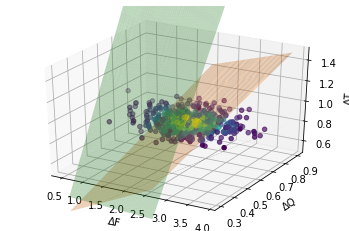

In [106]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')
plot_plane(1,ax)
plot_plane(1.9,ax)

plot_plane(5,ax)
ax.set_zlim(.5,1.5)


The likelihood of a particular $S_{hist}$ is the area of the intersection of the plane defined by $S_{hist}$ and the 3D kernel density.  Note that here, we're not $sampling$ values of $\Delta F$ or $\Delta Q$, we're just using them to define the plane.

In [107]:
likelihood = []
Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
Qs = np.linspace(.3,.9,nsamp)
Shist_possibilities = np.linspace(.1,5,num=nsamp)
for Shist in Shist_possibilities:
    #the plane is given by
    #Ts = Shist * (Fs-Qs)/dF2xCO2_dist
    Ts=Shist*(Fs-Qs)/F2x
    #now evaluate the kernel density on the plane using kde
    Svals=np.vstack((Fs,Qs,Ts))
    likelihood += [np.sum(kde(Svals))]

Now plot the likelihood of different values of $S_{hist}$

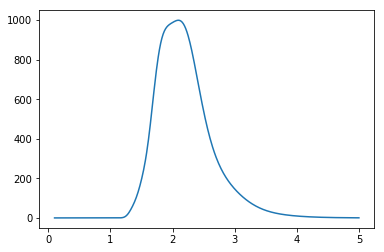

In [108]:
plt.plot(Shist_possibilities,likelihood)

In [109]:
Shist_possibilities[np.argmax(likelihood)]

2.093386773547094

What if the feedbacks $\lambda$ are not constant with time ($\lambda=\lambda(t)$)?  This can be parametrized (but is this the best way to do it?) by incorporating an ocean heat efficacy term:
$$\Delta F = \lambda \Delta T + \epsilon\Delta Q$$
or a forcing efficacy term:
$$\eta \Delta F = \lambda \Delta T + \Delta Q$$
These have the effect of tilting the plane in the $\Delta Q$ or $\Delta F$ directions.

In [130]:
%%capture
def plot_plane_efficacy(Shist,epsilon,forcingefficacy=1.,ax=plt.gca(),**kwargs):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/F2x*(forcingefficacy*xx-epsilon*yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist),**kwargs)

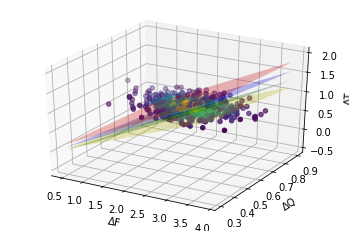

In [133]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')

plot_plane_efficacy(2,1,ax=ax,color="blue")
plot_plane_efficacy(2,.5,ax=ax,color="red")
plot_plane_efficacy(2,1.5,ax=ax,color="green")
plot_plane_efficacy(2,1,forcingefficacy=.8,ax=ax,color="yellow")



In [134]:
%%capture
def plot_historical_likelihood(epsilon,forcingefficacy=1,**kwargs):
    likelihood = []
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    Shist_possibilities = np.linspace(.1,10,num=nsamp)
    for Shist in Shist_possibilities:
        #the plane is given by
        #Ts = Shist * (Fs-Qs)/dF2xCO2_dist
        Ts=Shist*(forcingefficacy*Fs-epsilon*Qs)/F2x
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Fs,Qs,Ts))
        likelihood += [np.sum(kde(Svals))]
    plt.plot(Shist_possibilities,likelihood,**kwargs)

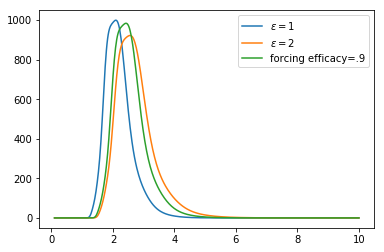

In [135]:
plot_historical_likelihood(1,label=r'$\epsilon=1$')
plot_historical_likelihood(1.5,label=r'$\epsilon=2$')
plot_historical_likelihood(1,forcingefficacy=0.9,label='forcing efficacy=.9')
plt.legend()

# Last Glacial Maximum

We assume the climate is in equilibrium ($\Delta Q = 0$.)  If there is no state dependence, then we can write 
$$S=\frac{F_{2\times CO_2} \Delta T}{\Delta F}.$$

In [114]:
%%capture
def plot_line(S):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,Ts*F2x/S)
    
    

However, it is possible that the feedbacks may be stronger or weaker in a cold climate.  To reflect this, we can expand 
$$\Delta F = \frac{\partial F}{\partial T}\Delta T + \frac{1}{2}\frac{\partial^2 F}{\partial T^2} \Delta T^2$$
and set $\alpha=\frac{1}{2}\frac{\partial^2 F}{\partial T^2}$.  In this case, we have 
$$\Delta T=\frac{\Delta F}{\lambda + \alpha \Delta T}$$

In [179]:
%%capture
def plot_complex_line(S,alpha,ax=plt.gca(),**kwargs):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,Ts*(F2x/S+alpha*Ts),**kwargs)
    

From paleo: We can reconstruct carbon dioxide (and thus forcing) and temperature.  
Last glacial to interglacial global mean temperature estimates range from 3K to 7K, so we'll take 
$$\Delta T_{LGM} = N(5,1). $$
Let's also assume that forcing is 
$$\Delta F_{LGM} = N(-8.8,2.0)$$
Once again, we can calculate the kernel density. For a given ECS and 

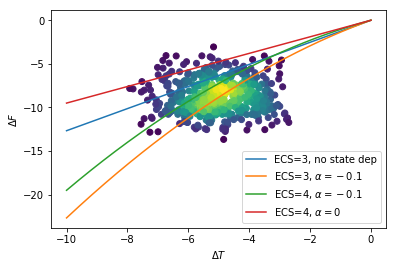

In [193]:

dT_LGM = np.random.normal(loc=-5.0,scale=1.0,size=nsamp)
dF_LGM = np.random.normal(loc=-8.8,scale=2.0,size=nsamp)
values_LGM = np.zeros((2,nsamp))
values_LGM[0]=dT_LGM
values_LGM[1]=dF_LGM
kde_LGM = stats.gaussian_kde(values_LGM)
density_LGM = kde_LGM(values_LGM)
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_complex_line(3,0,ax=ax,label="ECS=3, no state dep")

#plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(4,-.1,label=r"ECS=4, $\alpha=-0.1$")
plot_complex_line(4,0,label=r"ECS=4, $\alpha=0$")
plt.legend()

In [185]:
def get_LGM_likelihood(alpha,plot=True,print_max_likelihood=False):
    likelihood_LGM = []

    Ts = np.linspace(-10,0,nsamp)
    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the plane is given by
        Fs=Ts*(F2x/S+alpha*Ts)
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Ts,Fs))
        likelihood_LGM += [np.sum(kde_LGM(Svals))]
    if plot:
        plt.plot(S_possibilities,likelihood_LGM,label=r"$\alpha=$"+str(alpha))
        plt.xlabel("S")
        plt.ylabel("Likelihood")
    if print_max_likelihood:
        print("Max likelihood is "+str(S_possibilities[np.argmax(likelihood_LGM)]))
    else:
        return likelihood_LGM


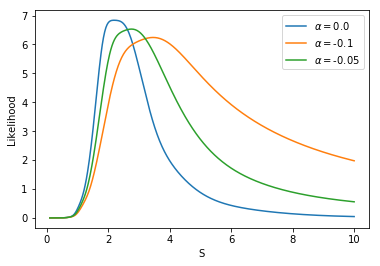

In [187]:
get_LGM_likelihood(0.)

get_LGM_likelihood(alpha=-0.1)
get_LGM_likelihood(alpha=-0.05)
plt.legend()

In [119]:
%%capture
def plot_forcing_efficacy(S,epsilon,ax=plt.gca(),beta=-0.6,**kwargs):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,F2x/epsilon*(Ts/S-beta)+beta*F2x,**kwargs)



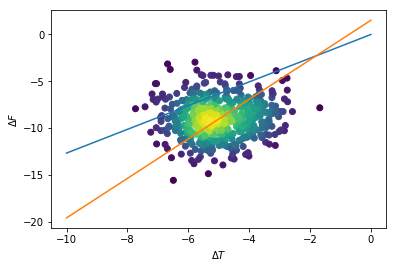

In [155]:

dT_LGM = np.random.normal(loc=-5.0,scale=1.0,size=nsamp)
dF_LGM = np.random.normal(loc=-8.8,scale=2.0,size=nsamp)
values_LGM = np.zeros((2,nsamp))
values_LGM[0]=dT_LGM
values_LGM[1]=dF_LGM
kde_LGM = stats.gaussian_kde(values_LGM)
density_LGM = kde_LGM(values_LGM)
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_forcing_efficacy(3,1)
plot_forcing_efficacy(3,.6)


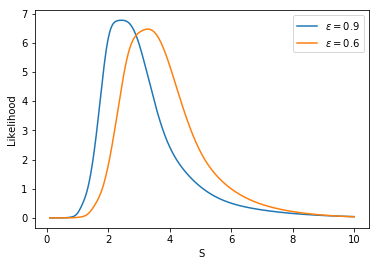

In [188]:
def get_LGM_efficacy_likelihood(epsilon,plot=True,beta=-0.6,print_max_likelihood=False):
    likelihood_LGM = []

    Ts = np.linspace(-10,0,nsamp)
   
    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the line is given by
        Fice=F2x/epsilon*(Ts/S-beta)
        Fs=Fice+beta*F2x
        
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Ts,Fs))
        likelihood_LGM += [np.sum(kde_LGM(Svals))]
    if print_max_likelihood:
        print("Max likelihood is "+str(S_possibilities[np.argmax(likelihood_LGM)]))
    if plot:
        plt.plot(S_possibilities,likelihood_LGM,label=r"$\epsilon=$"+str(epsilon))
        plt.xlabel("S")
        plt.ylabel("Likelihood")
    else:
        return likelihood_LGM
    
get_LGM_efficacy_likelihood(.9)
get_LGM_efficacy_likelihood(.6)

plt.legend()

Does it really matter whether the "state dependence" comes from the reduced temperature or the efficacy of the ice sheet forcings?

In [189]:
Fav=np.average(dF_LGM)
Tav=np.average(dT_LGM)
alpha_S=lambda S:(Fav-F2x/S*Tav)/(Tav**2)
print(alpha_S(3))
Fco2_LGM=-0.6*F2x
Fice_av=Fav-Fco2_LGM
epsilon_S=lambda S:(F2x/S * Tav - Fco2_LGM)/Fice_av
print(epsilon_S(3))


-0.0954954129523998
0.6298715686420303


Max likelihood is 3.175150300601203
Max likelihood is 3.373547094188377


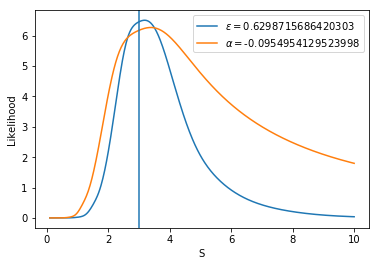

In [190]:
get_LGM_efficacy_likelihood(epsilon_S(3),print_max_likelihood=True)
get_LGM_likelihood(alpha_S(3),print_max_likelihood=True)
plt.legend()
plt.axvline(3)

-8.66159195487214
-8.66159195487214


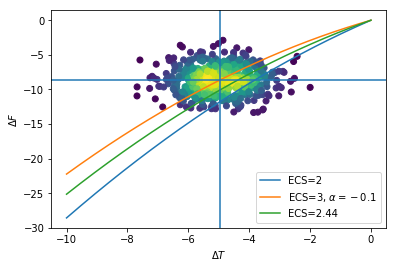

In [191]:
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_complex_line(2,alpha_S(3),ax=ax,label="ECS=2")

#plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(3,alpha_S(3),label=r"ECS=3, $\alpha=-0.1$")


plt.legend()
plt.axvline(Tav)
plt.axhline(Fav)

print(Tav*(F2x/3+alpha_S(3)*Tav))
print(Fav)

# Inferring ECS from the Pliocene

The mid-Pliocene , which occured 3.3-3.0 MYa, is the most recent analogue for a hot, high-CO$_2$ climate.  We take 
$$\Delta T_{pliocene} = N(3,1)$$
and 
$$\Delta CO2_{pliocene} = N(375,25)$$

In [22]:
%%capture
def plot_line_pliocene(S,ESS,ax=plt.gca()):
    Fs = np.linspace(0,4,num=nsamp)
    
    plt.plot(Fs,(S/F2x)*Fs*(1+ESS))


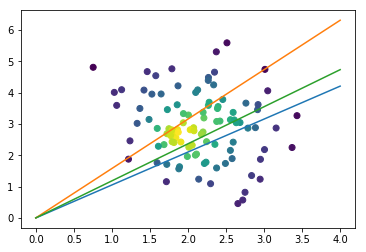

In [23]:
dT_pliocene = np.random.normal(loc=3.0,scale=1.0,size=nsamp)
dCO2_pliocene=np.random.normal(375.,scale=25.0,size=nsamp)
dFCO2_pliocene=np.log(dCO2_pliocene/280.)/np.log(2.0)*F2x
dF_pliocene=dFCO2_pliocene*(1+np.random.normal(.4,scale=0.1,size=nsamp))
values_pliocene = np.zeros((2,nsamp))
values_pliocene[1]=dT_pliocene
values_pliocene[0]=dF_pliocene
kde_pliocene = stats.gaussian_kde(values_pliocene)
density_pliocene = kde_pliocene(values_pliocene)
plt.scatter(dF_pliocene,dT_pliocene,c=density_pliocene)
plot_line_pliocene(4,0)
plot_line_pliocene(4,.5)
plot_line_pliocene(3,.5)

In [24]:
np.max(dF_pliocene)

3.4329192969513476

$S_{pliocene} = \frac{\Delta T_{pliocene} F_{2x}}{\Delta F_{CO2}(1+ESS)}$

In [25]:
%%capture
def get_pliocene_likelihood(ESS,plot=True):
    likelihood_pliocene = []
    Fs = np.linspace(0,5,nsamp)

    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the plane is given by
        Ts =(S/F2x)*Fs*(1+ESS)
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Fs,Ts))
        likelihood_pliocene += [np.sum(kde_pliocene(Svals))/np.sum(density_pliocene)]
    if plot:
        plt.plot(S_possibilities,likelihood_pliocene,label="fESS ="+str(ESS))
    else:
        return likelihood_pliocene
    

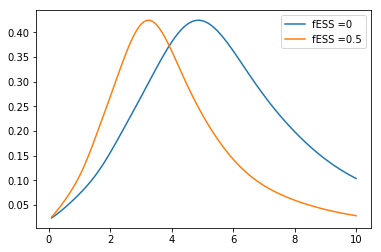

In [26]:
get_pliocene_likelihood(0)
get_pliocene_likelihood(.5)
plt.legend()

Let $\lambda = \lambda(\bar{T}+T'(r))$ where $\bar{T(r)} $ is the global mean temperature and $T'(r)$ the spatial anomaly pattern.  Then
$$\frac{d \lambda}{dt}=\frac{\partial \lambda}{\partial \bar{T}}  \frac{d\bar{T}}{dt} +\frac{\partial \lambda}{\partial T'}  \frac{d T'}{dt} = 2\alpha \frac{d\bar{T}}{dt} +\kappa  \frac{d T'}{dt} $$
The first term represents the state dependence $\alpha \equiv \frac{\partial^2 F}{\partial \bar{T}^2}$ multiplied by the global mean temperature, which changes with time.  The second term represents the pattern effect; $\kappa$ is the radiative kernel, assumed constant in time.

Assume exponentially decaying $T'(t)$.  Assume linear increase in T.
$$\frac{d \lambda}{dt}= C + K*\exp\left(-t/\tau\right)$$

 ## Efficacies And State Dependence From Hansen et al 2005

In [27]:
CO2 = [0.125,0.5,1.25,1.5,2.,4.,8.]
Es=[0.95,0.96,0.98,0.95,1.,1.03,1.02,1.02]
Esreg=[0.98,0.99,1,1.03,1.13,1.07,1.08,1.13]
TgFg=1.1/2.39

In [28]:
Ts=[-4.56,-3.32,-1.78,0.58,1.1,1.96,4.06,7.02]
Fs=[-10.3,-7.44,-3.91,1.32,2.38,4.11,8.58,13.97]
Fa=[-10.94,-7.74,-4.07,1.3,2.39,4.12,8.53,13.53]
Fi=[-12.68,-8.88,-4.61,1.44,2.64,4.52,9.27,14.65]

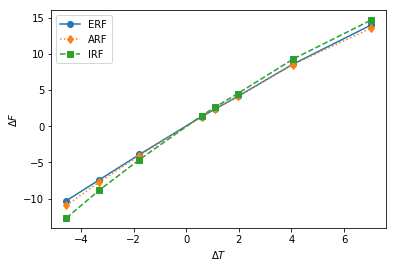

In [29]:
plt.plot(Ts,Fs,"o-",label="ERF")
plt.plot(Ts,Fa,"d:",label="ARF")
plt.plot(Ts,Fi,"s--",label="IRF")
plt.xlabel(r"$\Delta T$")
plt.ylabel(r"$\Delta F$")
plt.legend()

The main difference is in the stratosphere: stratospheric adjustments are larger in a cold climate

In [30]:
alpha_erf=np.polyfit(Ts,Fs,2)[0]
alpha_arf=np.polyfit(Ts,Fa,2)[0]
alpha_irf=np.polyfit(Ts,Fi,2)[0]

In [31]:
alpha_erf

-0.02489121028606511

Max likelihood is 2.4807615230460924
Max likelihood is 2.3022044088176354


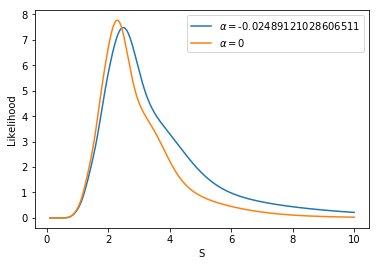

In [194]:
get_LGM_likelihood(alpha=alpha_erf,print_max_likelihood=True)
get_LGM_likelihood(alpha=0,print_max_likelihood=True)
#lgm_giss=get_LGM_likelihood(alpha=alpha_erf,plot=False)
#lgm_0=get_LGM_likelihood(alpha=0,plot=False)
#print(np.linspace(.1,10,num=nsamp)[np.argmax(lgm_giss)])
#np.linspace(.1,10,num=nsamp)[np.argmax(lgm_0)]
plt.legend()

In [33]:
Fi_solar=[-45.28,-22.64,-11.32,-4.53,4.53,11.32]
Fa_solar=[-45.87,-22.94,-11.47,-4.59,4.59,11.47]
Fs_solar=[-45.91,-22.69,-11.3,-4.51,4.52,11.11]
Ts_solar=[-26.85,-9.51,-4.53,-1.93,2.07,5.31]

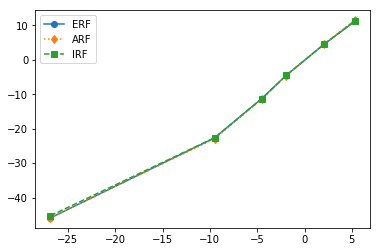

In [34]:
plt.plot(Ts_solar,Fs_solar,"o-",label="ERF")
plt.plot(Ts_solar,Fa_solar,"d:",label="ARF")
plt.plot(Ts_solar,Fi_solar,"s--",label="IRF")
plt.legend()

In [35]:
alpha_solar=np.polyfit(Ts_solar,Fs_solar,2)[0]

In [36]:
alpha_solar

0.02626568742522932